# <a href="Index">Index</a>
1. [Loader Data Set](#LoaderDataSet)
2. [Model](#model)

In [1]:
import torch
import numpy as np
from pathlib import Path
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
import torchvision
import torch.nn as nn
from torchvision import transforms
import os
import glob
import os.path as osp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#path=os.getcwd()+'/training_data_numpy/'
path='../project_data/'

# <a href="LoaderDataSet"> 1. Loader Data set</a> 
[Back to Index](#Index)

In [3]:
class MammogramDataset(Dataset):
    def __init__(self):
        self.files_features=[]
        self.files_labels=[]
        self.transform=transforms.ToTensor()
        
        #Features
        
        feature_files=glob.glob(osp.join(path,'*count*.npz'))
        feature_files=sorted(feature_files)
        
        for f in feature_files:
                #num_imgs=int(f[f.index(' '):f.index('.')])
                num_imgs=int(f.split(" ")[1].split(".")[0])
                for i in range(num_imgs):
                    self.files_features.append(f[:f.index('.npz')]+'-'+str(i)+'.npz')
        
        self.len=len(self.files_features)
        
        
        #Labels
        
        labels_files=glob.glob(osp.join(path,'*class_arr.npz'))
        labels_files=sorted(labels_files)
        
        first_array=np.load(labels_files[0])
        training_labels=first_array['arr_0']
        
        for f in range(len(labels_files)-1):
            array= np.load(labels_files[f])
            training_labels=np.concatenate((training_labels,array['arr_0']),axis=0)
        
        self.training_labels=training_labels
        
    
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        file=self.files_features[index]
        file_name=file[:file.index('-')]+'.npz'
        
        image_number=int(file.split("-")[1].split(".npz")[0])
        array_feature= np.load(file_name)
        selected_feature=array_feature['arr_0'][:,:,image_number]
        
        label=self.training_labels[index]
        
        
        return self.transform(selected_feature), label
    
    def __len__(self):
        return self.len

In [4]:
mam=MammogramDataset()

In [5]:
print(len(mam))

55885


label: 0


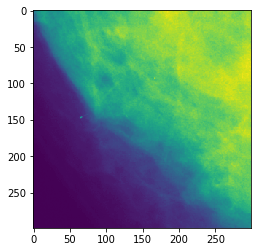

In [6]:
datapoint=mam[0]
image=datapoint[0]
label=datapoint[1]
print("label:", label)

plt.imshow(image[0].numpy())

In [7]:
loader_dataset = data_utils.DataLoader(mam, batch_size=4, shuffle = True)

In [8]:
batch = next(iter(loader_dataset))

In [9]:
images, labels = batch

In [10]:
labels

tensor([0, 2, 0, 0])

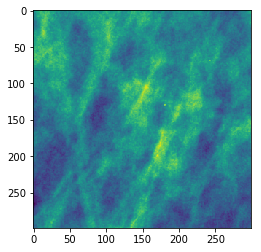

In [11]:
plt.imshow((images[0].squeeze()))

# <a href="model"> 2. Model </a>
[Back to Index](#Index)

In [16]:
images.squeeze().shape

torch.Size([4, 299, 299])

## <a href="simpleModel">2.1 Simple Model</a>

In [48]:
#dtype = torch.long
torch.set_default_dtype(torch.float64)
device = torch.device("cpu")

N, D_in, H, D_out = 4, 299*299, 100, 5


model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
)

criterion = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_iters=3


for t in range(num_iters):
    
    batch = next(iter(loader_dataset))
    images, labels=batch
    
    x=images.squeeze()
    x=x.reshape(x.shape[0],np.product(x.shape[1:]))
    #x=x.long()
    
    y=torch.nn.functional.one_hot(labels, D_out).double()
    #y=y.long()
    print(labels)
    print(x.shape)
    print(y.shape)
    print(y.max())
    print(x.type())
    print(y.type())
    #linear=torch.nn.Linear(D_in, H)
    #linear(x)
    y_pred=model(x)
    
    loss = criterion(y_pred, y)
    print(t, loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()




tensor([0, 0, 0, 0])
torch.Size([4, 89401])
torch.Size([4, 5])
tensor(1.)
torch.DoubleTensor
torch.DoubleTensor
0 17126.648599675114


MemoryError: 

In [18]:
np.product([1,2,3])

6

In [160]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12 * 4 * 4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=2)
        
    def forward(self, t):
        # implement the forward pass
        # (1) input layer
        t = t

        # (2) hidden conv layer
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (3) hidden conv layer
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # (4) hidden linear layer
        t = t.reshape(-1, 12 * 4 * 4)
        t = self.fc1(t)
        t = F.relu(t)

        # (5) hidden linear layer
        t = self.fc2(t)
        t = F.relu(t)

        # (6) output layer
        t = self.out(t)
        #t = F.softmax(t, dim=1)

        return t

In [162]:

network=Network()
preds = network(images)

RuntimeError: Expected object of scalar type Double but got scalar type Float for argument #2 'weight'